In [10]:
import argparse
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader

from multissl.data import SemiSupervisedSegmentationDataset,SegmentationDataset, semi_supervised_collate_fn
from multissl.plotting.false_color import visualize_batch_semi , visualize_predictions, visualize_batch
from multissl.models import MeanTeacherSegmentation, SegmentationModel
from multissl.data.seg_transforms import create_mean_teacher_augmentations

In [19]:
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "unlabeled_dir": ["../dataset/vineseg/imgs/train_qbaixo5","../dataset/vineseg/imgs/train_valdoeiro5",  ],  # Optional path or list of paths to unlabeled images
    "img_size": 224,
    "batch_size": 4,
    "num_workers": 0,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_r18/last.ckpt", #None, #
    "backbone_type": "resnet18",  # Options: resnet18, resnet50, vit-s, swin-tiny
    "num_classes": 2,
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 300,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "consistency_weight": 1.0,
    "consistency_rampup": 10,  # Epochs for ramping up consistency weight
    "check_val_every_n_epoch": 5,  # Validate every N epochs
    
    # Domain adaptation parameters
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs (None to keep frozen)
    
    # Misc
    "seed": 42,
    "class_names": ["Background", "Vines"],  # Update with your class names
    "checkpoint_dir": "domain_adaptive_checkpoints",
    "project_name": "1SHOT_Segmentation",
    "class_names": ["Background","Vines"],  # Update with your class names
    "class_weights": [1.0,1.0],

    "aug_p": 0.3, # heavyness of augments for the mean teacher,
    "ema_decay": 0.999,
    "confidence_threshold": 0.8
}

In [20]:
# Create train/val/test datasets
pl.seed_everything(CONFIG["seed"])

train_dataset =SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "train_1vary"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "train_1vary"),
    img_size=CONFIG["img_size"]
)



test_dataset_e = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "val_esac2"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "val_esac2"),
    img_size=CONFIG["img_size"]
)

test_dataset_v = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_valdoeiro"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_valdoeiro"),
    img_size=CONFIG["img_size"]
)

test_dataset_q = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_qbaixo"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_qbaixo"),
    img_size=CONFIG["img_size"]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True)

val_loader = DataLoader(
        test_dataset_e,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=CONFIG["num_workers"],
        pin_memory=True
    )


test_loader_e = DataLoader(
    test_dataset_e,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader_v = DataLoader(
    test_dataset_v,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
test_loader_q = DataLoader(
    test_dataset_q,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(test_dataset_e)}")
print(f"Test dataset size valdoeiro: {len(test_dataset_v)}")
print(f"Test dataset size qbaixo: {len(test_dataset_q)}")

Seed set to 42


Train dataset size: 3
Validation dataset size: 97
Test dataset size valdoeiro: 157
Test dataset size qbaixo: 141


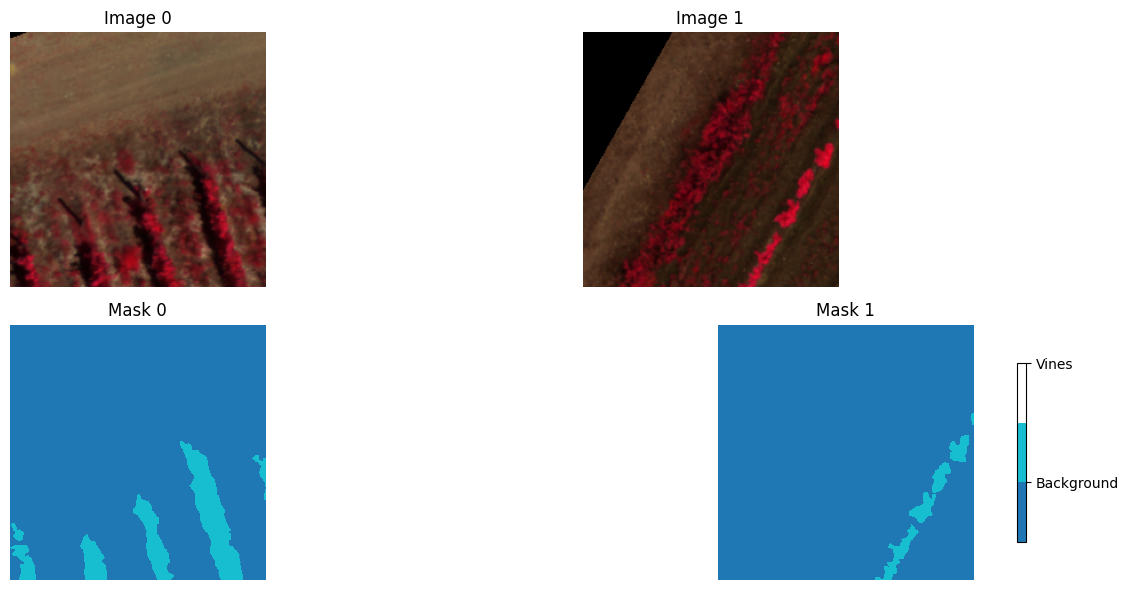

In [21]:
# Visualize a batch of training data
batch = next(iter(train_loader))
visualize_batch(
    batch, 
    num_samples=2, 
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [22]:
# For ResNet50 pretrained with FastSiam
model = SegmentationModel(
        backbone_type=CONFIG["backbone_type"],
        pretrained_path=CONFIG["pretrained_checkpoint"],
        in_channels=CONFIG["in_channels"],
        num_classes=CONFIG["num_classes"],
        img_size=CONFIG["img_size"],
        lr=CONFIG["lr"],
        weight_decay=CONFIG["weight_decay"],
        class_weights=CONFIG["class_weights"],
    )

Detected feature dimensions: layer1=64, layer2=128, layer3=256, layer4=512


In [23]:
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_callback = ModelCheckpoint(
    dirpath="segmentation_checkpoints",
    filename="r18_1shot-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb

wandb_logger = WandbLogger(project=CONFIG["project_name"], log_model=False)

# Create trainer
trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="cuda",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, RichProgressBar()],
    logger=wandb_logger,  # Comment out if not using wandb
    check_val_every_n_epoch=5  # Only validate every 5 epochs
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
# Train the model
trainer.fit(model, train_loader, val_loader)
import wandb
wandb.finish()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name              ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ feature_extractor │ ResNetBackbone     │ 11.2 M │ train │
│ 1 │ seg_head          │ ResNetBackboneUNet │  3.9 M │ train │
└───┴───────────────────┴────────────────────┴────────┴───────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 11.2 M                                                                                       
Total params: 15.1 M                                                                                               
Total estimated model params size (MB): 60                                                                         
Modules in train mode: 128                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425
: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the
`num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of 
training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for 
log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=300` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
lr-AdamW,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▄▃▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_accuracy,▁▁▁▁▁▁▁▁▁▃▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██████
val_loss,█▇▇▅▅▅▅▅▄▃▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,299
lr-AdamW,0.0003
train_loss_epoch,0.0008
train_loss_step,0.0008


Detected feature dimensions: layer1=64, layer2=128, layer3=256, layer4=512
Loaded best model from C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints\r18_1shot-epoch=89-val_loss=0.4985.ckpt


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.4886
Accuracy: 0.7830
Total F1 Score (micro-avg): 0.7830
Mean IoU: 0.4596

Per-class metrics:
Background:
  Precision: 0.7763
  Recall: 0.9904
  F1 Score: 0.8673
  IoU: 0.7702
Vines:
  Precision: 0.7441
  Recall: 0.1533
  F1 Score: 0.2516
  IoU: 0.1490

Confusion Matrix:
tensor([[3548751,   36356],
        [1052168,  229797]], device='cuda:0')


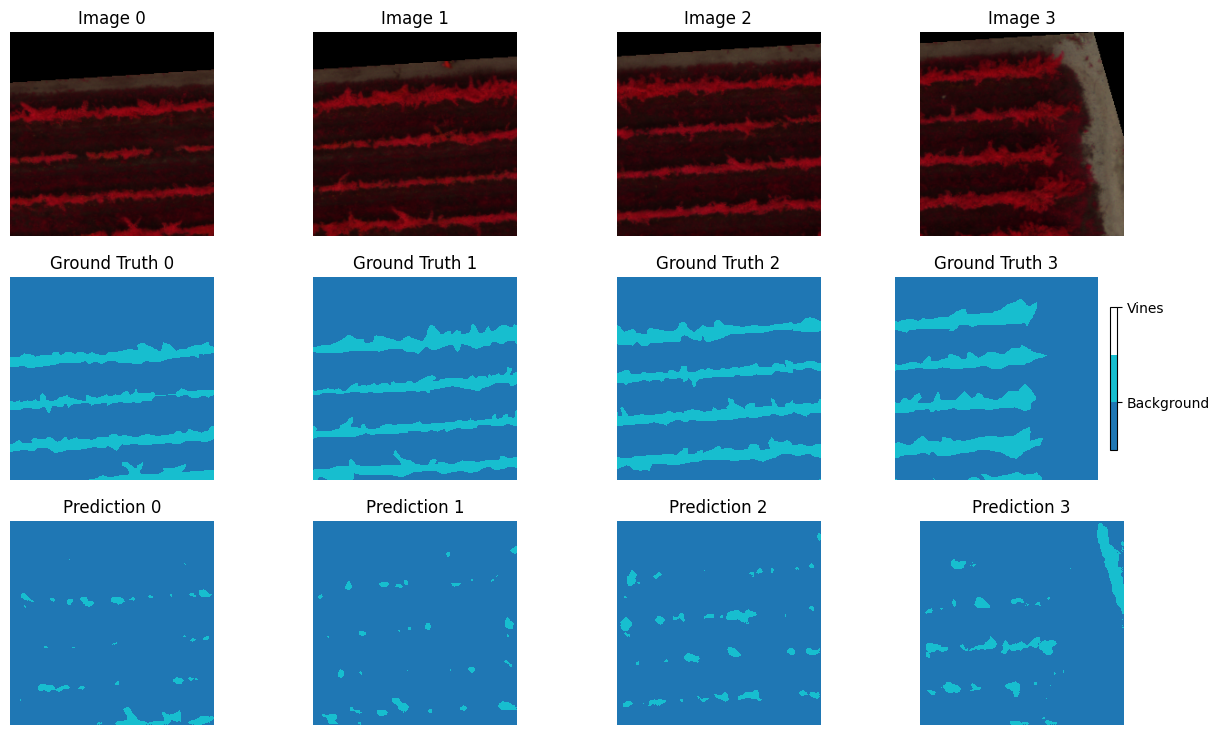

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.2337
Accuracy: 0.9498
Total F1 Score (micro-avg): 0.9498
Mean IoU: 0.6662

Per-class metrics:
Background:
  Precision: 0.9506
  Recall: 0.9972
  F1 Score: 0.9733
  IoU: 0.9481
Vines:
  Precision: 0.9326
  Recall: 0.3991
  F1 Score: 0.5480
  IoU: 0.3844

Confusion Matrix:
tensor([[7217383,   20124],
        [ 380661,  259464]], device='cuda:0')


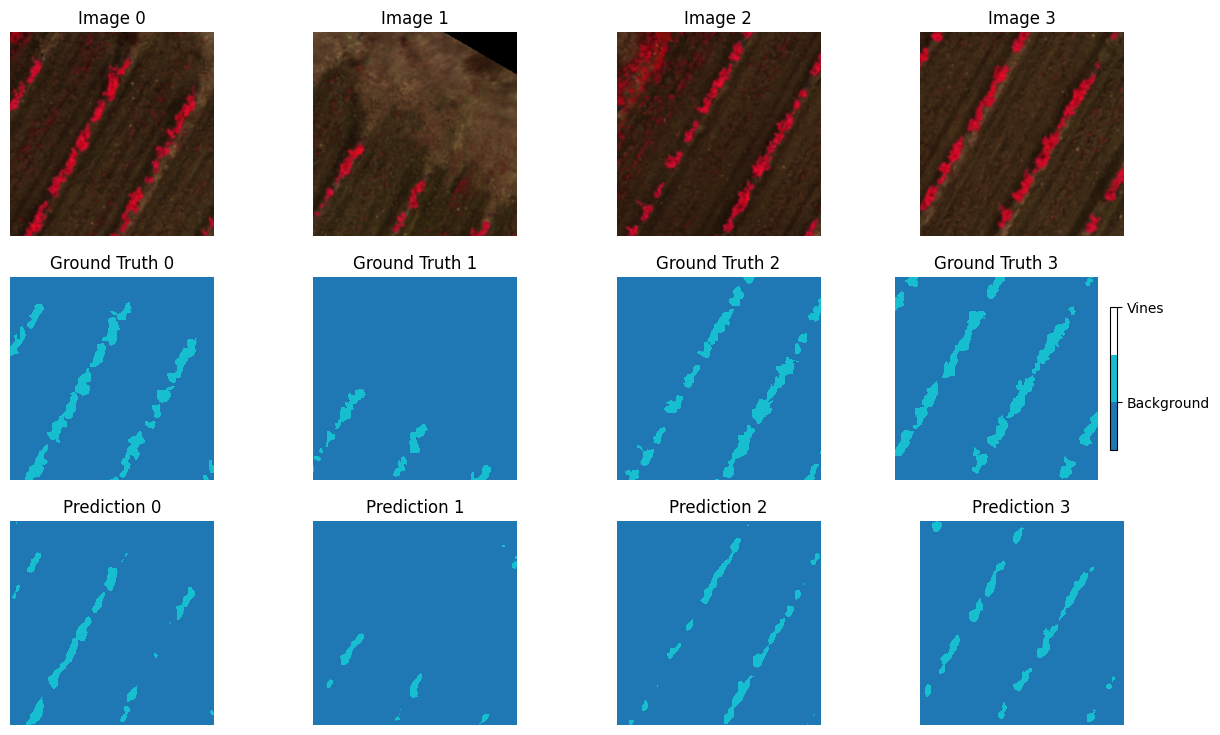

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.4150
Accuracy: 0.8406
Total F1 Score (micro-avg): 0.8406
Mean IoU: 0.5632

Per-class metrics:
Background:
  Precision: 0.8545
  Recall: 0.9672
  F1 Score: 0.9060
  IoU: 0.8295
Vines:
  Precision: 0.7140
  Recall: 0.3455
  F1 Score: 0.4492
  IoU: 0.2969

Confusion Matrix:
tensor([[5483500,  181120],
        [ 951318,  458878]], device='cuda:0')


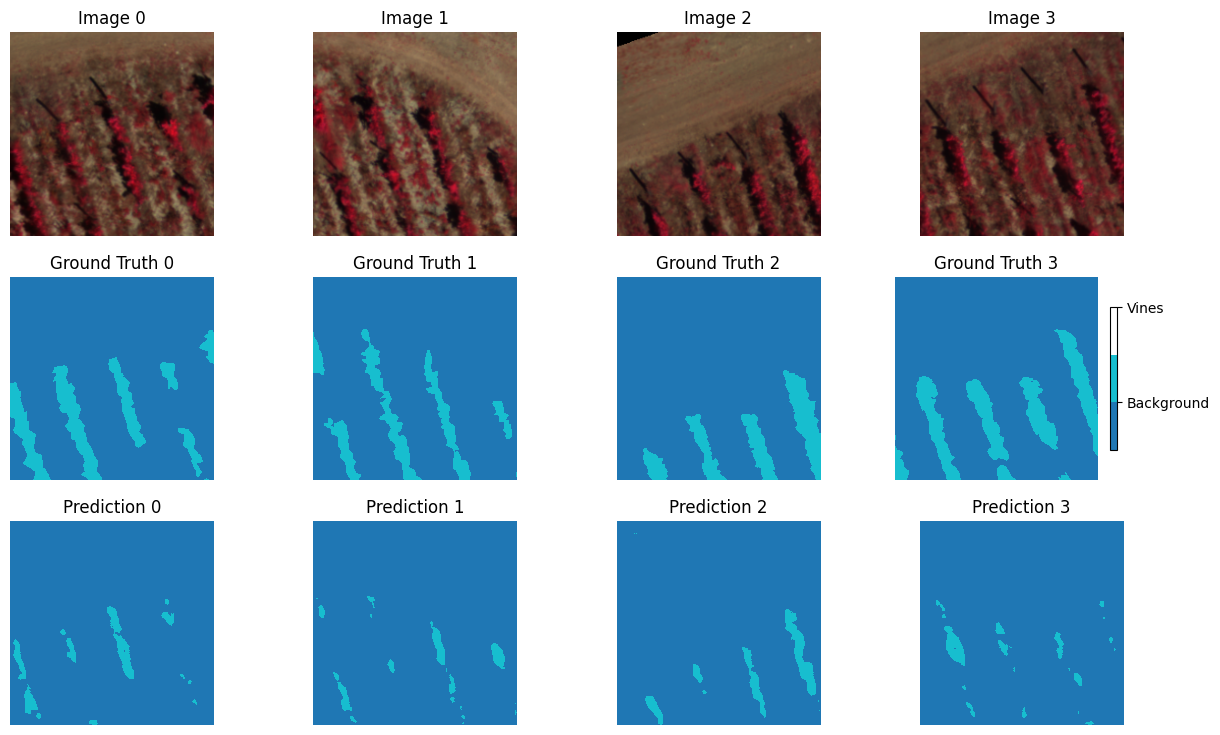

In [25]:
# Load the best model
device = "cuda"

best_model_path = checkpoint_callback.best_model_path
best_model = SegmentationModel.load_from_checkpoint(best_model_path, 
                                                    backbone_type = CONFIG["backbone_type"])

best_model.eval()

print(f"Loaded best model from {best_model_path}")

uber_test_results_e2 = best_model.test(val_loader)

visualize_predictions(
    model=best_model,
    dataloader=val_loader,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_v = best_model.test(test_loader_v)


visualize_predictions(
    model=best_model,
    dataloader=test_loader_v,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_q = best_model.test(test_loader_q)

visualize_predictions(
    model=best_model,
    dataloader=test_loader_q,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [26]:
# Save just the state dict for easier loading in production
# ineseg_r18_1shot_all_bb task_achitecture_dataset_backbone 
# architecture: r18, r50, swin
# dataset: 1shot, 1shot_all,
# backbone: bb, ee (pretrained, end-to-end)
model_state_dict_path = "segmentation_checkpoints/vineseg_r18_1shot_all_bb.pth"
torch.save(best_model.state_dict(), model_state_dict_path)
print(f"Saved model state dict to {model_state_dict_path}")

Saved model state dict to segmentation_checkpoints/vineseg_r18_1shot_all_bb.pth
